#### Imports

In [4]:
import torch.autograd as autograd

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [5]:
from FCN import FCN
from tools import *

In [6]:
%matplotlib inline

### Function Tools

In [15]:
def partial_diff_equation(f, g):
    f_x_y = autograd.grad(f,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True)[0] #first derivative
    f_xx_yy = autograd.grad(f_x_y,g,torch.ones(g.shape), create_graph=True)[0]#second derivative

    f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
    f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

    u = f_xx + f_yy # loss equation
    u = u.float()

    return u

#### 1.1. Setup and calculation

In [11]:
myProblem = Problem(partial_diff_equation, squareHasHole = False, hasInternalHeat = False, evolutiveWeights= False)

X_train_PDE, X_train_Nu, T_train_Nu, X_test = myProblem.getDomains()

X_train, T_train = myProblem.X_train, myProblem.T_train

x = myProblem.X[:,0]
y = myProblem.Y[0,:]

N_x, N_y = myProblem.N_x, myProblem.N_y

/Users/thyagocapitanio/anaconda3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
PINN = FCN(myProblem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_files/PINN_simple.pt'))

<All keys matched successfully>

In [14]:
arr_bc = np.loadtxt('./history_files/loss_bc_history_simple.csv', delimiter= ",", dtype= float)
arr_pde = np.loadtxt('./history_files/loss_pde_history_simple.csv', delimiter= ",", dtype= float)
arr_total = np.loadtxt('./history_files/loss_history_simple.csv', delimiter= ",", dtype= float)

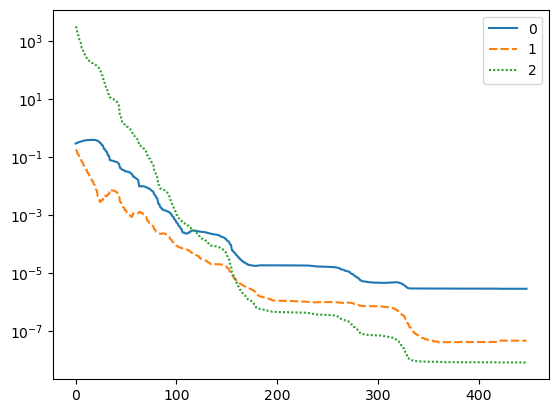

In [15]:
sns.lineplot([arr_bc, arr_pde, arr_total])
plt.yscale('log')

In [17]:
def loss_PDE(FCN, x_PDE):
        x_PDE = torch.from_numpy(x_PDE)

        g = x_PDE.clone()
        g.requires_grad = True

        f = FCN.forward(g)

        u = FCN.partial_diff_equation(f, g)

        print(u)

        u_hat = torch.zeros(x_PDE.shape[0],1)  
        u_hat = u_hat.float()

        loss = FCN.loss_function(u, u_hat)

        FCN.loss_pde_history.append(loss.item())

        return loss 

In [18]:
loss_PDE(PINN, X_train_PDE)

tensor([[ 0.0023],
        [ 0.0003],
        [-0.0002],
        ...,
        [ 0.0024],
        [ 0.0017],
        [-0.0004]], dtype=torch.float32, grad_fn=<ToCopyBackward0>)


tensor(3.0630e-06, dtype=torch.float32, grad_fn=<MseLossBackward0>)

In [45]:
def Loss2D(FCN):
    def lossFunction(x, y):
        g = torch.from_numpy(np.array([[x, y]], dtype = float))
        g.requires_grad = True
        f = FCN.forward(g)

        f_x_y = autograd.grad(f, g, torch.ones([g.shape[0],1]), retain_graph=True, create_graph=True)[0] #first derivative
        f_xx_yy = autograd.grad(f_x_y, g, torch.ones(g.shape), create_graph=True)[0]#second derivative

        f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
        f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

        return (f_xx + f_yy)**2

    return integrate2D(lossFunction)
    
    

In [ ]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))

In [ ]:
lossTensor = PINN.lossTensor(X_test)
lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x,N_y))